# Clasificador de piezas de arte

- Curso: INFO257 Inteligencia Artificial
- Profesor: Pablo Huijse 
- Consultas por slack o correo: phuijse at inf dot uach dot cl 

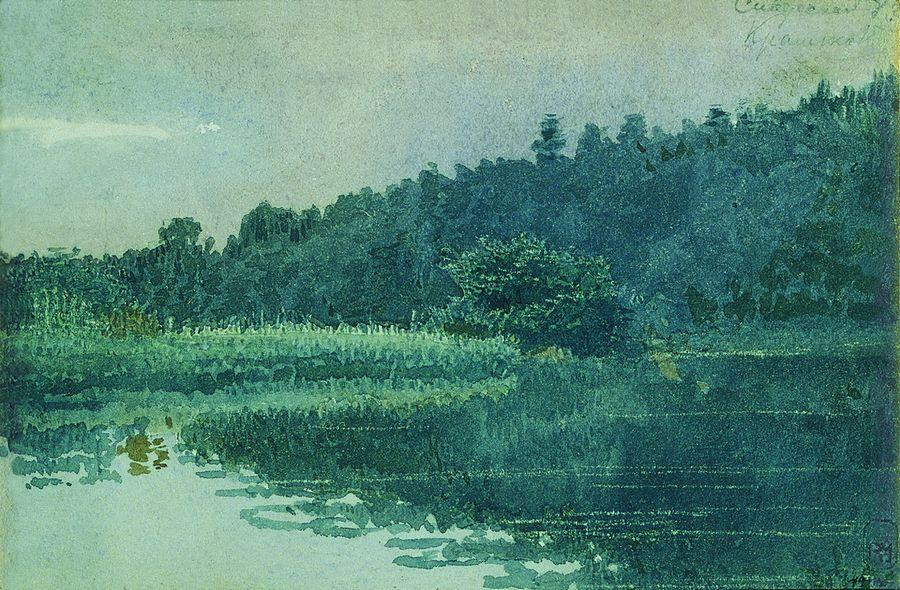

["Siverskaya" del pintor Ivan Kramskoy,1982](https://www.wikiart.org/en/ivan-kramskoy/siverskaya-1883)

## Objetivo

> El objetivo de esta actividad es entrenar y evaluar una red neuronal profunda para clasificar automáticamente el estilo de una pintura. Usted entrenará este modelo usando un conjunto de 1,000 imágenes de 10 estilos distintos. Las imágenes fueron obtenidas de la enciclopedia de arte visual [WikiArt.org](https://www.wikiart.org/)



## Datos

Para resolver esta tarea se le ha proporcionado una base de datos que puede descargar en el siguiente enlace: 

> https://drive.google.com/file/d/14JO2UMUnNYCyDGr_8qHVA_s4zn0d33pT/view?usp=sharing

La base de datos ya está separada en conjuntos de entrenamiento y prueba según los archivos de texto plano incluidos `train.txt` y `test.txt`, respectivamente. Se recomienda crear un script de Python que lea estos archivos y organice las imágenes tal que sean compatibles con [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder)

Las etiquetas se entregan como un entero de 0 a 9 cuyo significado es

- 0: [Art Nouveau o Modernismo](https://es.wikipedia.org/wiki/Modernismo_(arte))
- 1: [Barroco](https://es.wikipedia.org/wiki/Barroco)
- 2: [Expresionismo](https://es.wikipedia.org/wiki/Expresionismo)
- 3: [Impresionismo](https://es.wikipedia.org/wiki/Impresionismo)
- 4: [Neoclasicismo](https://es.wikipedia.org/wiki/Neoclasicismo)
- 5: [Posimpresionismoo](https://es.wikipedia.org/wiki/Posimpresionismo)
- 6: [Realismo](https://es.wikipedia.org/wiki/Realismo_art%C3%ADstico)
- 7: [Romanticismo](https://es.wikipedia.org/wiki/Romanticismo)
- 8: [Surrealismo](https://es.wikipedia.org/wiki/Surrealismo)
- 9: [Symbolism](https://es.wikipedia.org/wiki/Simbolismo)

## Instrucciones generales

- Se trabajará en grupos de dos personas. Informe los integrantes del grupo a su profesor a la brevedad
- El grupo debe crear un repositorio privado en www.github.com 
- Invite a su profesor como colaborador (usuario: phuijse)
- No suba los datos al repositorio, suba sólo sus códigos fuente y reportes de resultado
- Se evaluará en base al último *commit* del Lunes 11 de Enero de 2021
- [Sean honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish)


## Instrucciones específicas

En esta tarea usted debe seleccionar, entrenar y evaluar un modelo profundo para resolver el problema anteriormente presentado

1. Seleccione un modelo del módulo [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) y descríbalo en detalle. Se recomienda revisar las publicaciones asociadas
1. Use el modelo  seleccionado pre-entrenado en ImageNet como extractor de características
1. Utilice un esquema de tipo *transfer learning* para entrenar el modelo. Usted debe diseñar una nueva cabeza clasificadora para el modelo seleccionado y decidir cuales/cuantas capas congelar. 

Indicaciones
- Separe el conjunto de entrenamiento en dos subconjuntos para ajustar los parámetros y calibrar los hiperparámetros, respectivamente. Proponga e implemente estrategias para prevenir el sobreajuste del modelo
- Evalue la capacidad de generalización de su modelo final midiendo su rendimiento en el conjunto de prueba. Presente sus resultados usando curvas de aprendizaje, matrices de confusión, *accuraccy* y *f1-score*. 
- Documente el proceso iterativo que lo llevó a decidir su arquitectura final. Justifique sus decisiones de función de costo, optimizador, arquitectura, regularización, etc. Analice sus resultados, inspeccione los errores del modelo. Comente, discuta y concluya

## Desarrollo

**Integrantes**:
- Reinaldo Bustamante
- María Belén Barrientos

### Modelo

Para elegir el modelo a implementar, analizamos la tabla presentada en la documentación de torchvision (https://pytorch.org/docs/stable/torchvision/models.html), la cual nos muestra las tasas de error de cada modelo por ImageNet. A continuación podemos ver cuáles son los tres modelos que tienen menor tasa:

|Network|Top-1 Error|Top-5 Error|
|---|---|---|
|ResNeXt-101-32x8d|20.69|5.47|
|Wide ResNet-101-2|21.16|5.72|
|Wide ResNet-50-2|21.49|5.91|

Basados en esta tabla, decidimos usar el modelo ResNeXt-101-32x8d, ya que tiene la menor tasa de error.

#### Descripción

ResNeXt está inspirado en los modelos VGG y ResNet y adopta la estrategia de repetición de capas mientras explota la estrategia de separar, transformar y fusionar. Esta arquitectura está compuesta por un stack de bloques residuales que tienen la misma topología y están sujetos a dos reglas inspiradas en los modelos antes mencionados. En primer lugar, si se producen mapas espaciales del mismo tamaño, los bloques comparten los hiperparámetros (ancho y tamaños de los filtros), segundo, cada vez que el mapa espacial es reducido por un factor de 2, el ancho de los bloques se multiplica por un factor de 2. Esta última regla asegura que la complejidad computacional es aproximadamente igual para todos los bloques.

Con estas reglas en mente se construyó el diseño de las redes que vemos a continuación.
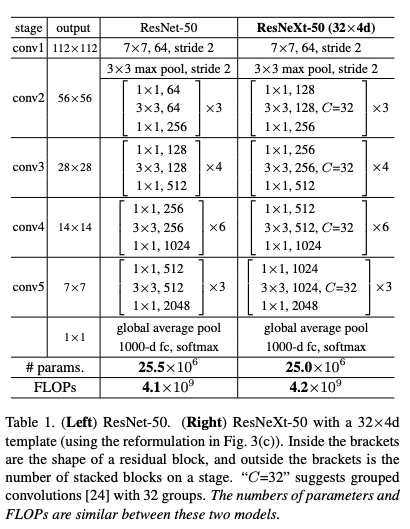

ResNeXt reemplaza la operación elemental de una neurona por una función más genérica, la cual se puede considerar una red por si misma. De esta forma, las transformaciones agregadas quedan representadas con la siguiente ecuación,

$$ \digamma(x) = \sum_{i=1}^{C}\tau_{i}(x)$$ 
<center><i><small>Ecuación (1)</small></i></center>

donde $\tau_{i}(x)$ puede ser una función arbitraria, y análogamente a una neurona simple, $\tau_{i}(x)$ debe proyectar $x$ en un embedding y transformarla.  

$C$ corresponde al tamaño del set de transformaciones a agregar (**Cardinalidad**), la cardinalidad es una dimensión esencial que puede ser más efectiva que las dimensiones del ancho y profundidad.

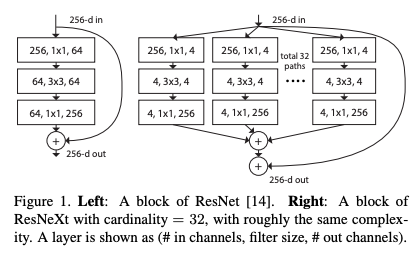

En la Figura 1, se muestra que la arquitectura tiene forma de cuello de botella, la cual está establecida por la transformación $\tau_{i}$, en este caso la primera capa de 1x1 en cada $\tau_{i}$ produce el embedding de baja dimensionalidad.  

Además la transformación agregada (Ecuación 1), sirve como la función residual en el esquema derecho de la figura 1, donde $y$ es la salida

$$y = x + \sum_{i=1}^{C}\tau_{i}(x)$$
<center><i><small>(2)</small></i></center>

En la Figura 3(b), podemos ver la relación con el bloque *Inception-ResNet* al cual se parece, sin embargo, la diferencia se encuentra en que la topología es la misma para los múltiples caminos, por lo que el módulo de ResNeXt requiere un mínimo esfuerzo extra en el diseño de cada camino.

Figura3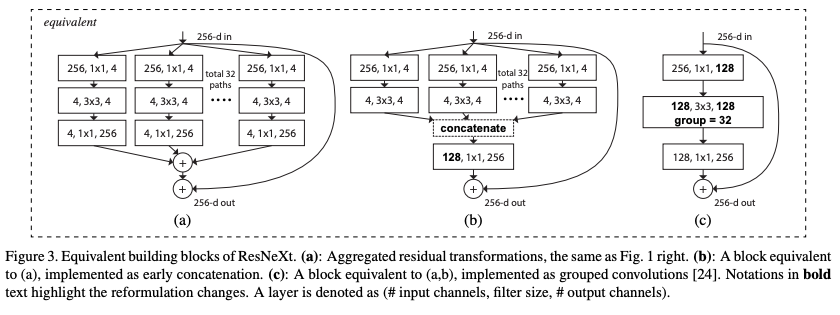

En la Figura 3(c) se ve la reformulación del módulo usando la notación de convolución agrupada. Todos los embeddings de baja dimesionalidad pueden ser por una única y más ancha capa. La división está hecha esencialmente por la capa convolucional agrupada cuando divide sus canales de entrada en grupos. Esta capa, realiza 32 grupos de convoluciones donde los canales de entrada y salida son de 4 dimensiones. Así, el bloque de la Figura 3(c) se parece al cuello de botella original del bloque residual de la Figura 1(izquierda), con la diferencia de que este es un módulo más ancho y escasamente conectado.

Los experimentos registrados en el paper que presenta los modelos ResNeXt (https://arxiv.org/pdf/1611.05431.pdf), muestran que la precisión de estos modelos mejora la de los ResNet cuando se mantiene la complejidad de este y el número de parámetros.

In [82]:
from torchvision import models

model = models.resnet18(pretrained=True, progress=True)
display(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Podemos apreciar que la arquitectura de ResNeXt se basa en Resnet, y que la estructura usada es, finalmente, como la presentada en la Figura 3(c).

Vemos que el layer1 está compuesto por 3 capas convolucionales, conv1 y conv3 con un kernel de 1x1 y conv2 con un kernel de 3x3, padding de 1 y 32 grupos, este último parámetro es la principal diferencia con la arquitectura original de ResNet como es mencionado más arriba. Después de cada capa convolucional se realiza una normalización de batch y luego de esta se aplica ReLU. En el layer2 volvemos a encontrar 3 capas convolucionales con las mismas características del layer1, pero esta vez conv2 tiene un paso de 2, después de aplicar ReLU en este layer, se hace un downsample. 

El layer3 es igual al layer2, con la diferencia que cuenta con más neuronas. El layer4 también es igual a los anteriores. Luego de estas capas, encontramos la de averagepool y la capa final.


### Preparación de Datos

In [72]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import os
import shutil

def organizeImages(file, source, destination):
    with open(file) as f:
        for line in f.readlines():
            x = line.rstrip().split(' ')
            title = x[0].split('/')[1]
            try:
                shutil.move(source + x[0], destination + x[1] + '/' + title)
            except OSError:
                os.makedirs(destination + x[1])
                shutil.move(source + x[0], destination + x[1] + '/' + title)
        print('Las imagenes se organizaron correctamente')

In [18]:
organizeImages('wikiart/train.txt', 'wikiart/', 'wikiart/images/input/')
organizeImages('wikiart/test.txt', 'wikiart/', 'wikiart/images/test/')

Las imagenes se organizaron correctamente
Las imagenes se organizaron correctamente


A continuación separamos el dataset de entrenamiento en train y validation

In [19]:
import splitfolders

splitfolders.ratio("wikiart/images/input", output="wikiart/images/", seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 810 files [00:03, 214.95 files/s]


### Implementación Modelo

**-------------------SUJETO A CAMBIOS-------------------**

Se establecen las transformaciones necesarias para que el dataset pueda ser analizado por el modelo preentreanado, también se usa aumentación de datos para el conjunto de entrenamiento

<IPython.core.display.Javascript object>


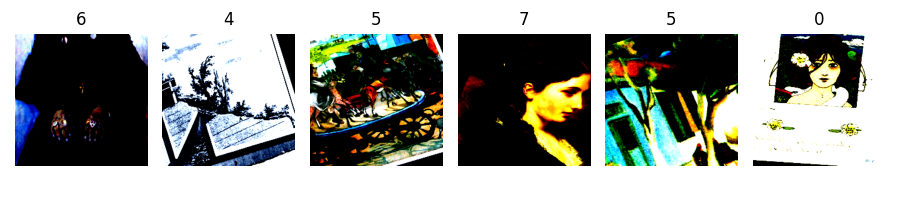

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [83]:
from torchvision import datasets
from torchvision import transforms
import torch

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('wikiart/images/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('wikiart/images/val', transform=valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

for image, label in train_loader:
    break
    
fig, ax = plt.subplots(1, 6, figsize=(9, 2), tight_layout=True)
for i in range(6):
    ax[i].imshow(image[i].permute(1,2,0).numpy())
    ax[i].axis('off')
    ax[i].set_title(label[i].numpy())

Considerando el tamaño del dataset (pequeño) y de que este no tiene demasiado parecido a los dataset de ImageNet con los que fue entrenado nuestro modelo, es necesario cambiar más capas aparte de la última para que le modelo se adapte de buena forma a nuestro problema.

**--------------------TEST CAMBIANDO CAPAS------------------------**

Se cuenta la cantidad de capas que tiene el modelo en total

In [84]:
count = 0
for child in model.children():
    count+=1
print(count)

10


Nuestro modelo tiene 10 capas, congelaremos n y cambiaremos los pesos de las otras m

In [85]:
#Se congelan n capas
count = 0
for child in model.children():
  count+=1
  if count < 8: #Cambiar n por la cantidad de capas a congelar +1
    for param in child.parameters():
        param.requires_grad = False

In [86]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.engine import Engine

# Recuperamos el número de neuronas de la última capa
neurons = model.fc.in_features 
# La reemplazamos por una nueva capa de salida
model.fc = torch.nn.Linear(neurons, 10) 

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epochs = 100

device = torch.device('cpu')
#device = torch.device('cuda')

model = model.to(device)

# Esto es lo que hace el engine de entrenamiento
def train_one_step(engine, batch):
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    yhat = model.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    return loss.item() # Este output puede llamar luego como trainer.state.output

# Esto es lo que hace el engine de evaluación
def evaluate_one_step(engine, batch):
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model.forward(x)
        #loss = criterion(yhat, y)
        return yhat, y

trainer = Engine(train_one_step)
evaluator = Engine(evaluate_one_step)
early_stopping = EarlyStopping(patience=10, score_function=lambda engine: -engine.state.metrics['Loss'], trainer=trainer)
metrics = {'Loss': Loss(criterion), 'Acc': Accuracy()}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [87]:
import time
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers import ModelCheckpoint

# Contexto de escritura de datos para tensorboard
with SummaryWriter(log_dir=f'/tmp/tensorboard/run{time.time_ns()}') as writer:

    @trainer.on(Events.EPOCH_COMPLETED(every=1)) # Cada 1 epocas
    def log_results(engine):
        # Evaluo el conjunto de entrenamiento
        evaluator.run(train_loader) 
        writer.add_scalar("train/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("train/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
        # Evaluo el conjunto de validación
        evaluator.run(valid_loader) 
        writer.add_scalar("valid/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("valid/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
    # Guardo el mejor modelo en validación
    best_model_handler = ModelCheckpoint(dirname='.', require_empty=False, filename_prefix="best", n_saved=1,
                                         score_function=lambda engine: -engine.state.metrics['Loss'],
                                         score_name="val_loss")

    # Lo siguiente se ejecuta cada ves que termine el loop de validación
    evaluator.add_event_handler(Events.COMPLETED,
                                best_model_handler, {'resnet18': model})
    evaluator.add_event_handler(Events.COMPLETED, early_stopping)

    trainer.run(train_loader, max_epochs=max_epochs)

In [88]:
model.load_state_dict(torch.load('best_resnet18_val_loss=-0.3890.pt'))

<All keys matched successfully>

<IPython.core.display.Javascript object>


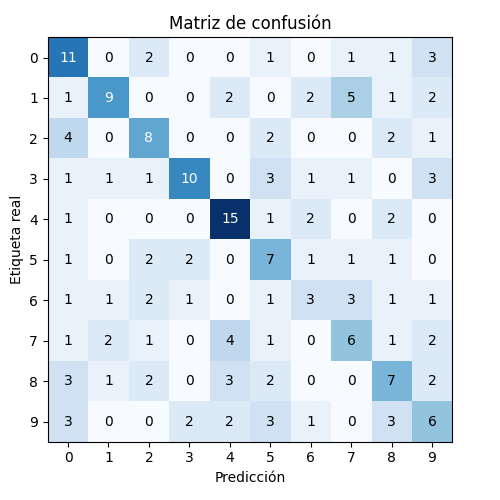

              precision    recall  f1-score   support

           0      0.407     0.579     0.478        19
           1      0.643     0.409     0.500        22
           2      0.444     0.471     0.457        17
           3      0.667     0.476     0.556        21
           4      0.577     0.714     0.638        21
           5      0.333     0.467     0.389        15
           6      0.300     0.214     0.250        14
           7      0.353     0.333     0.343        18
           8      0.368     0.350     0.359        20
           9      0.300     0.300     0.300        20

    accuracy                          0.439       187
   macro avg      0.439     0.431     0.427       187
weighted avg      0.452     0.439     0.436       187



In [89]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_dataset = datasets.ImageFolder('wikiart/images/test', transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=512)

targets, predictions = [], []
for mbdata, label in test_loader:
    logits = model.forward(mbdata)
    predictions.append(logits.argmax(dim=1).detach().numpy())
    targets.append(label.numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=targets, y_pred=predictions)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])

print(classification_report(targets, predictions, digits=3))

### Análisis de Errores

<ipython-input-113-83f33c31b44d>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 9, figsize=(8, 1.5), tight_layout=True)


<IPython.core.display.Javascript object>


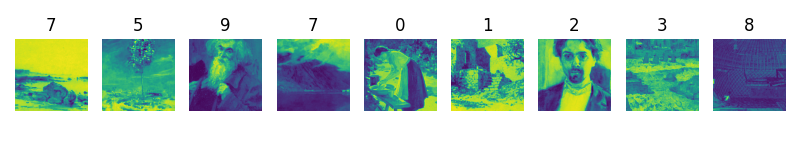

In [113]:
category = 6
idx = np.where((targets == category) & ~(predictions == category))[0]

fig, ax = plt.subplots(1, 9, figsize=(8, 1.5), tight_layout=True)
for i in range(9):
    ax[i].imshow(test_dataset[idx[i]][0].numpy()[0, :, :])
    ax[i].set_title(predictions[idx[i]])
    ax[i].axis('off')

<IPython.core.display.Javascript object>


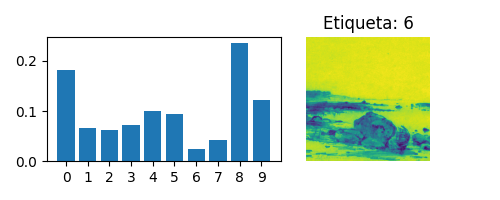

In [122]:
image, label = test_dataset[115]
# Usamos unsqueeze para convertirlo en un minibatch de 1 elemento:
y = torch.nn.Softmax(dim=1)(model.forward(image.unsqueeze(0)))

fig, ax = plt.subplots(1, 2, figsize=(5, 2), tight_layout=True)
ax[0].bar(range(10), height=y.detach().numpy()[0])
ax[0].set_xticks(range(10))
ax[1].set_title("Etiqueta: %d" %(label))
ax[1].imshow(image.numpy()[0, :, :]);
ax[1].axis('off');

**-------------------TEST OTROS MODELOS------------------**

In [123]:
from torchvision import models

model2 = models.resnet34(pretrained=True, progress=True)
display(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<IPython.core.display.Javascript object>


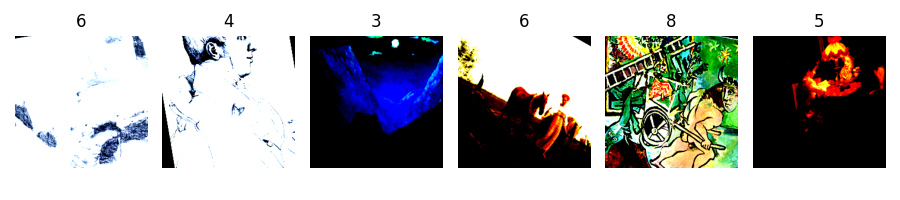

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [124]:
from torchvision import datasets
from torchvision import transforms
import torch

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('wikiart/images/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('wikiart/images/val', transform=valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

for image, label in train_loader:
    break
    
fig, ax = plt.subplots(1, 6, figsize=(9, 2), tight_layout=True)
for i in range(6):
    ax[i].imshow(image[i].permute(1,2,0).numpy())
    ax[i].axis('off')
    ax[i].set_title(label[i].numpy())

In [126]:
count = 0
for child in model2.children():
    count+=1
print(count)

10


In [127]:
#Se congelan n capas
count = 0
for child in model2.children():
  count+=1
  if count < 7: #Cambiar n por la cantidad de capas a congelar +1
    for param in child.parameters():
        param.requires_grad = False

In [128]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.engine import Engine

# Recuperamos el número de neuronas de la última capa
neurons = model2.fc.in_features 
# La reemplazamos por una nueva capa de salida
model2.fc = torch.nn.Linear(neurons, 10) 

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
max_epochs = 100

device = torch.device('cpu')
#device = torch.device('cuda')

model2 = model2.to(device)

# Esto es lo que hace el engine de entrenamiento
def train_one_step(engine, batch):
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    yhat = model2.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    return loss.item() # Este output puede llamar luego como trainer.state.output

# Esto es lo que hace el engine de evaluación
def evaluate_one_step(engine, batch):
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model2.forward(x)
        #loss = criterion(yhat, y)
        return yhat, y

trainer = Engine(train_one_step)
evaluator = Engine(evaluate_one_step)
early_stopping = EarlyStopping(patience=10, score_function=lambda engine: -engine.state.metrics['Loss'], trainer=trainer)
metrics = {'Loss': Loss(criterion), 'Acc': Accuracy()}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [129]:
import time
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers import ModelCheckpoint

# Contexto de escritura de datos para tensorboard
with SummaryWriter(log_dir=f'/tmp/tensorboard/run{time.time_ns()}') as writer:

    @trainer.on(Events.EPOCH_COMPLETED(every=1)) # Cada 1 epocas
    def log_results(engine):
        # Evaluo el conjunto de entrenamiento
        evaluator.run(train_loader) 
        writer.add_scalar("train/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("train/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
        # Evaluo el conjunto de validación
        evaluator.run(valid_loader) 
        writer.add_scalar("valid/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("valid/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
    # Guardo el mejor modelo en validación
    best_model_handler = ModelCheckpoint(dirname='.', require_empty=False, filename_prefix="best", n_saved=1,
                                         score_function=lambda engine: -engine.state.metrics['Loss'],
                                         score_name="val_loss")

    # Lo siguiente se ejecuta cada ves que termine el loop de validación
    evaluator.add_event_handler(Events.COMPLETED,
                                best_model_handler, {'resnet34': model2})
    evaluator.add_event_handler(Events.COMPLETED, early_stopping)

    trainer.run(train_loader, max_epochs=max_epochs)

In [130]:
model2.load_state_dict(torch.load('best_resnet34_val_loss=-0.4679.pt'))

<All keys matched successfully>

<IPython.core.display.Javascript object>


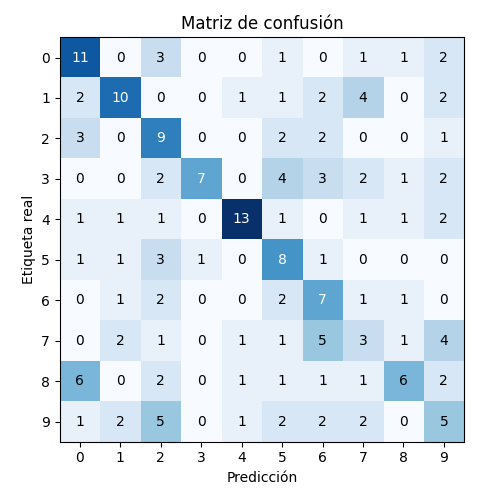

              precision    recall  f1-score   support

           0      0.440     0.579     0.500        19
           1      0.588     0.455     0.513        22
           2      0.321     0.529     0.400        17
           3      0.875     0.333     0.483        21
           4      0.765     0.619     0.684        21
           5      0.348     0.533     0.421        15
           6      0.304     0.500     0.378        14
           7      0.200     0.167     0.182        18
           8      0.545     0.300     0.387        20
           9      0.250     0.250     0.250        20

    accuracy                          0.422       187
   macro avg      0.464     0.427     0.420       187
weighted avg      0.482     0.422     0.426       187



In [131]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_dataset = datasets.ImageFolder('wikiart/images/test', transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=512)

targets, predictions = [], []
for mbdata, label in test_loader:
    logits = model2.forward(mbdata)
    predictions.append(logits.argmax(dim=1).detach().numpy())
    targets.append(label.numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=targets, y_pred=predictions)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])

print(classification_report(targets, predictions, digits=3))

In [143]:
from torchvision import models

model3 = models.resnet18(pretrained=True, progress=True)

<IPython.core.display.Javascript object>


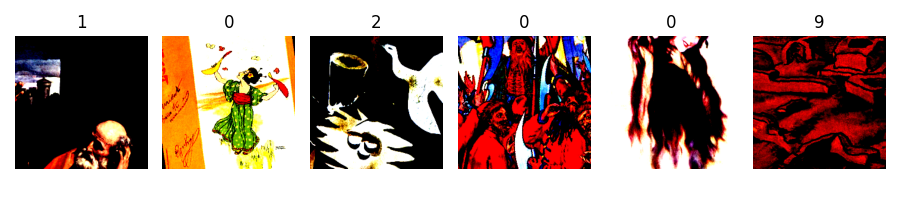

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [144]:
from torchvision import datasets
from torchvision import transforms
import torch

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('wikiart/images/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('wikiart/images/val', transform=valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

for image, label in train_loader:
    break
    
fig, ax = plt.subplots(1, 6, figsize=(9, 2), tight_layout=True)
for i in range(6):
    ax[i].imshow(image[i].permute(1,2,0).numpy())
    ax[i].axis('off')
    ax[i].set_title(label[i].numpy())

In [146]:
count = 0
for child in model3.children():
    count+=1
print(count)

10


In [147]:
#Se congelan n capas
count = 0
for child in model3.children():
  count+=1
  if count < 10: #Cambiar n por la cantidad de capas a congelar +1
    for param in child.parameters():
        param.requires_grad = False

In [148]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.engine import Engine

# Recuperamos el número de neuronas de la última capa
neurons = model3.fc.in_features 
# La reemplazamos por una nueva capa de salida
model3.fc = torch.nn.Linear(neurons, 10) 

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)
max_epochs = 100

device = torch.device('cpu')
#device = torch.device('cuda')

model3 = model3.to(device)

# Esto es lo que hace el engine de entrenamiento
def train_one_step(engine, batch):
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    yhat = model3.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    return loss.item() # Este output puede llamar luego como trainer.state.output

# Esto es lo que hace el engine de evaluación
def evaluate_one_step(engine, batch):
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model3.forward(x)
        #loss = criterion(yhat, y)
        return yhat, y

trainer = Engine(train_one_step)
evaluator = Engine(evaluate_one_step)
early_stopping = EarlyStopping(patience=10, score_function=lambda engine: -engine.state.metrics['Loss'], trainer=trainer)
metrics = {'Loss': Loss(criterion), 'Acc': Accuracy()}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [149]:
import time
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers import ModelCheckpoint

# Contexto de escritura de datos para tensorboard
with SummaryWriter(log_dir=f'/tmp/tensorboard/run{time.time_ns()}') as writer:

    @trainer.on(Events.EPOCH_COMPLETED(every=1)) # Cada 1 epocas
    def log_results(engine):
        # Evaluo el conjunto de entrenamiento
        evaluator.run(train_loader) 
        writer.add_scalar("train/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("train/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
        # Evaluo el conjunto de validación
        evaluator.run(valid_loader) 
        writer.add_scalar("valid/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("valid/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
    # Guardo el mejor modelo en validación
    best_model_handler = ModelCheckpoint(dirname='.', require_empty=False, filename_prefix="best", n_saved=1,
                                         score_function=lambda engine: -engine.state.metrics['Loss'],
                                         score_name="val_loss")

    # Lo siguiente se ejecuta cada ves que termine el loop de validación
    evaluator.add_event_handler(Events.COMPLETED,
                                best_model_handler, {'resnet18v2': model3})
    evaluator.add_event_handler(Events.COMPLETED, early_stopping)

    trainer.run(train_loader, max_epochs=max_epochs)

In [150]:
model3.load_state_dict(torch.load('best_resnet18v2_val_loss=-1.1745.pt'))

<All keys matched successfully>

<IPython.core.display.Javascript object>


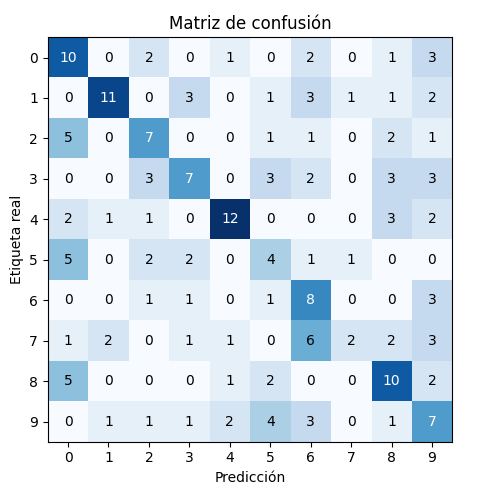

              precision    recall  f1-score   support

           0      0.357     0.526     0.426        19
           1      0.733     0.500     0.595        22
           2      0.412     0.412     0.412        17
           3      0.467     0.333     0.389        21
           4      0.706     0.571     0.632        21
           5      0.250     0.267     0.258        15
           6      0.308     0.571     0.400        14
           7      0.500     0.111     0.182        18
           8      0.435     0.500     0.465        20
           9      0.269     0.350     0.304        20

    accuracy                          0.417       187
   macro avg      0.444     0.414     0.406       187
weighted avg      0.458     0.417     0.416       187



In [151]:
test_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_dataset = datasets.ImageFolder('wikiart/images/test', transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=512)

targets, predictions = [], []
for mbdata, label in test_loader:
    logits = model3.forward(mbdata)
    predictions.append(logits.argmax(dim=1).detach().numpy())
    targets.append(label.numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=targets, y_pred=predictions)
plot_confusion_matrix(cm, labels=[str(i) for i in range(10)])

print(classification_report(targets, predictions, digits=3))